<a href="https://colab.research.google.com/github/Ssellu/modu-adversarial-examples/blob/main/modu-02-pgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

사전 훈련된 MobileNetV2 모델과 ImageNet의 클래스(class) 이름들을 불러옵니다.


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [ ]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## 원본 이미지
Mirko CC-BY-SA 3.0의 래브라도 리트리버 샘플 이미지를 이용해 적대적 샘플을 생성합니다. 첫 단계로, 원본 이미지를 전처리하여 MobileNetV2 모델에 입력으로 제공합니다.

In [ ]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 [==============================] - 1s 778ms/step


이미지를 살펴봅시다.

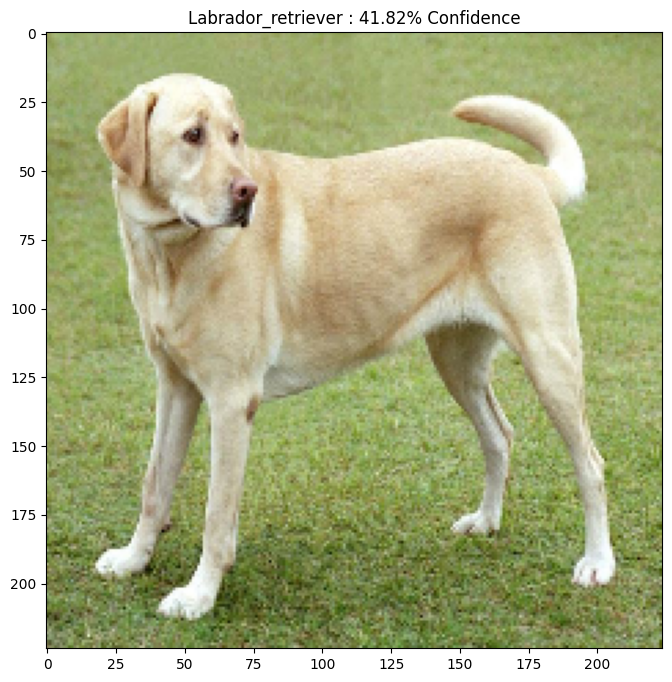

In [ ]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

# 적대적 이미지 생성하기
## PGD 실행하기
FGSM을 여러번 반복하는 것으로 PGD를 수행할 수 있습니다.

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label, model, epsilon=0.01, num_steps=40, step_size=0.01):
    adv_image = input_image
    for i in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            prediction = model(adv_image)
            loss = loss_object(input_label, prediction)
        gradient = tape.gradient(loss, adv_image)
        signed_grad = tf.sign(gradient)
        # 적용된 노이즈를 계산
        adv_image = adv_image + step_size * signed_grad
        # epsilon 범위 내로 제한
        adv_image = tf.clip_by_value(adv_image, input_image - epsilon, input_image + epsilon)
        # [0, 1] 범위 내로 제한
        adv_image = tf.clip_by_value(adv_image, 0, 1)
    # 생성된 노이즈만 반환
    return adv_image - input_image

생성한 왜곡을 시각화해 볼 수 있습니다.

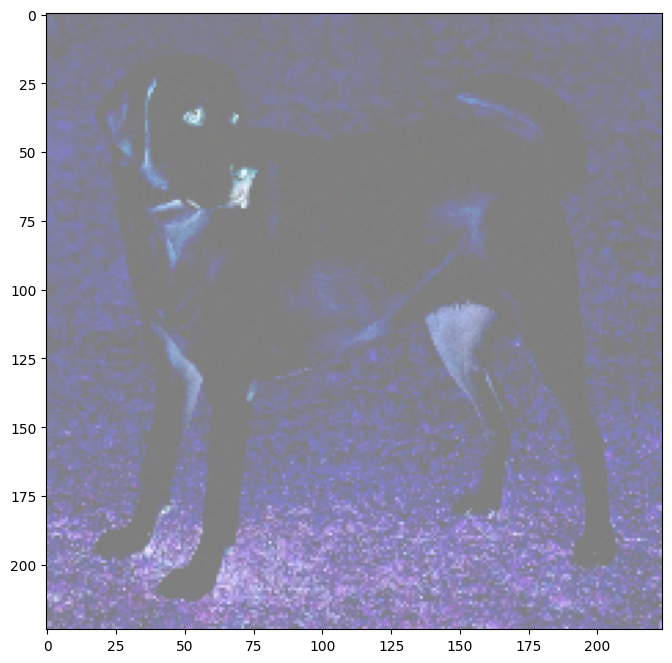

In [ ]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

# Create perturbations using PGD
perturbations = create_adversarial_pattern(image, label, pretrained_model)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # Adjust the visualization

왜곡 승수 엡실론(epsilon)을 바꿔가며 다양한 값들을 시도해봅시다. 위의 간단한 실험을 통해 엡실론의 값이 커질수록 네트워크를 혼란시키는 것이 쉬워짐을 알 수 있습니다. 하지만 이는 이미지의 왜곡이 점점 더 뚜렷해진다는 단점을 동반합니다.

In [ ]:
def display_images(adv_image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(adv_image))
    plt.figure()
    plt.imshow(adv_image[0])
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
    plt.show()

1/1 [==============================] - 0s 22ms/step


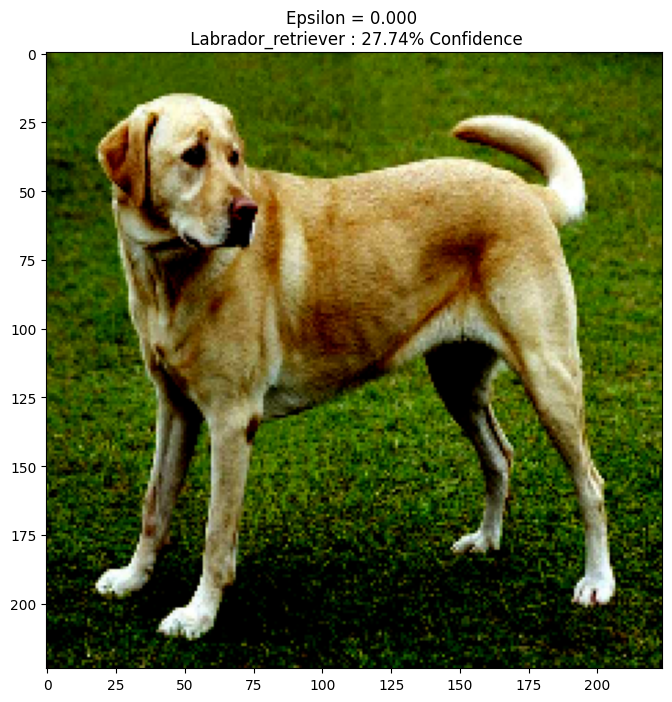

1/1 [==============================] - 0s 22ms/step


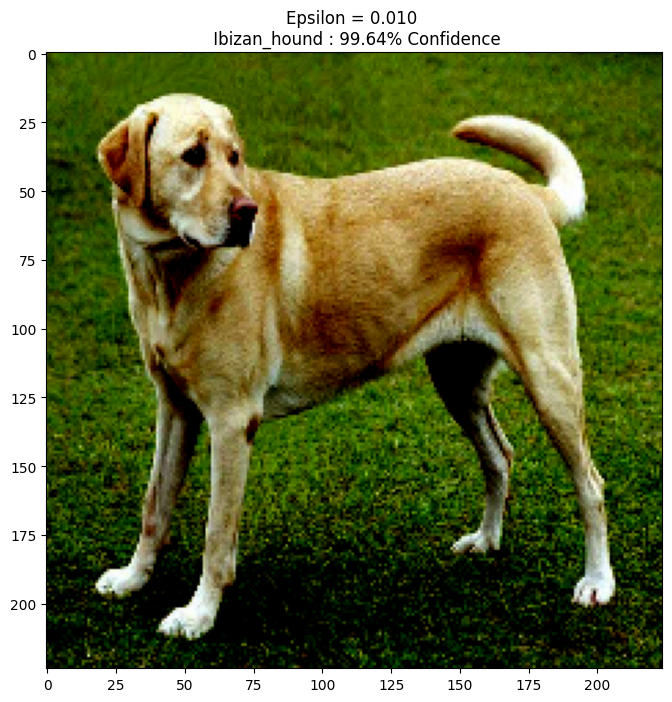

1/1 [==============================] - 0s 23ms/step


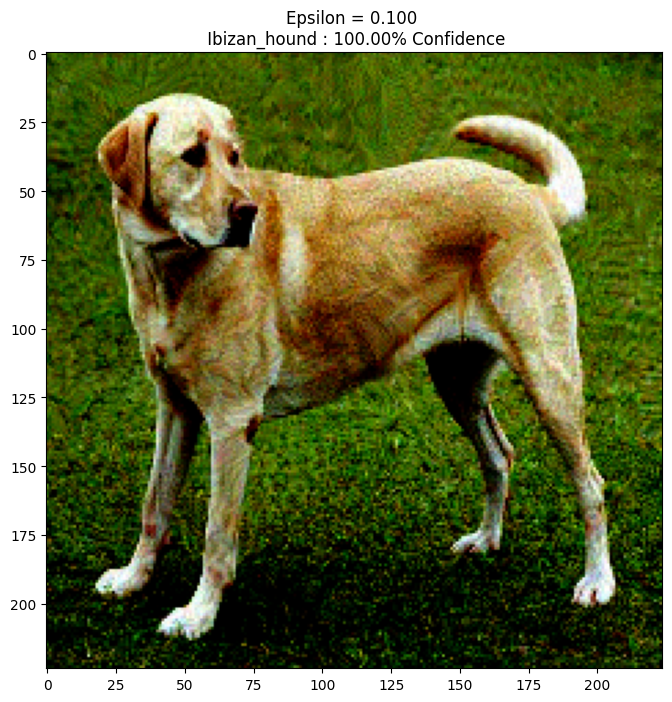

1/1 [==============================] - 0s 24ms/step


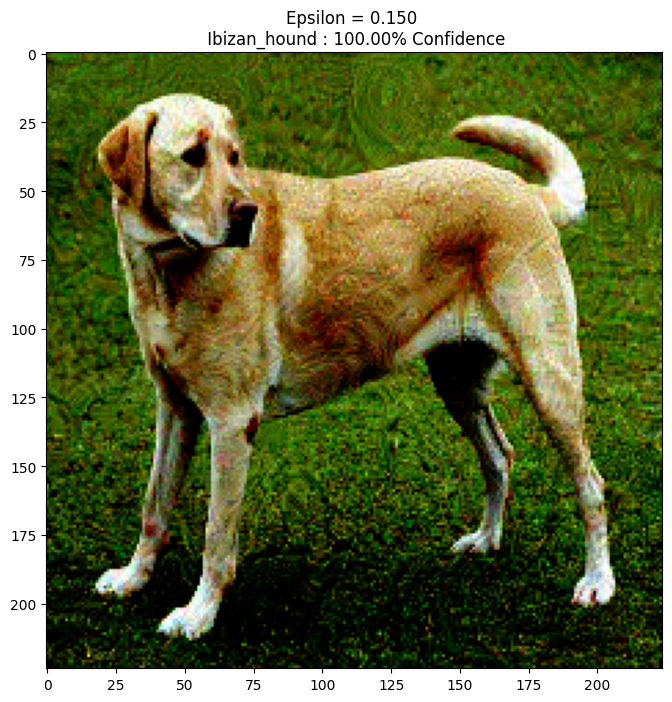

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15]

for eps in epsilons:
    # Generate adversarial noise with specified epsilon
    noise = create_adversarial_pattern(image, label, pretrained_model, epsilon=eps)
    # Apply the noise to the original image and clip to [0, 1]
    adv_image = tf.clip_by_value(image + noise, 0, 1)
    display_images(adv_image, 'Epsilon = {:0.3f}'.format(eps))